# **Предварительный анализ данных и построение признаков в задачах распознавания объектов на фотографии**

**Выполнил:** Белов Константин, студент группы ПМ22-7

**Научный руководитель:** Соловьёв Владимир Игоревич, доктор экономических наук, профессор.

## Введение

**Тема курсовой работы:** Предварительный анализ данных и построение признаков в задачах распознавания объектов на фотографии

Для удобства проведения исследования выбранная тема будет рассмотрена на примере решения реальной практической задачи: выявление дефектов в производстве стальных тросов.

Ручная проверка выявления дефектов малоэффективна, возможности проверить каждый произведённый продукт нет, остаётся только выборочная проверка. Соответственно, появляется необходимость автоматизировать процесс. Для этого можно применить технологии компьютерного зрения (Computer Vision), для определения наличия дефектов по изображению.

Так, предлагается решить задачу обнаружения объектов на изображении (Object Detection).

**Цель:** изучение имеющихся методов подготовки и сбора данных в задачах распознавания объектов на фото и применение их на практике.

**Задачи:**

1. Ознакомиться с имеющимися методами работы с графическими данными;  
2. Ознакомиться с существующими моделями компьютерного зрения, применяемыми в задачах обнаружения объектов;  
3. Собрать данные;  
4. Провести описательный анализ данных;  
5. Провести необходимую предобработку данных;  
6. Обучить модель;  
8. Оценить метрики;  
9. Сделать выводы;  

**Компьютерное зрение (Computer Vision)** - раздел машинного обучения, занимающийся задачами получения, обработки и анализа графической информации с последующим получением из неё знаний посредством алгоритмов.

Поставленная задача, как было обозначено ранее - **обнаружение объектов на изображении** (**Object Detection**). По сути задача решается в два этапа - **локализация объекта** (определения местоположения объекта на изображении) и **классификация объекта** (определения, что за объект перед нами).

## Используемые библиотеки

In [2]:
# Замеры времени
import time

# Работа с табличными и числовыми данными
import numpy as np
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Навигация по директориям
import os

# Работа с изображениями
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

# Доступ к датасету (roboflow), модель YOLO
from roboflow import Roboflow
from ultralytics import YOLO
import yaml

from roboflow_token import APIKEY

np.bool = np.bool_

## Датасет. Описательный анализ

Датасет для целей моделирования был получен из онлайн репозитория датасетов Roboflow Universe. Сам датасет представлен изображениями стальных тросов с различными дефектами.

Данный датасет уже размечен. То есть, содержит метки, определяющие, где на изображении находится искомый дефект.

Для обучения моделей компьютерного зрения важно, чтобы датасет обладал следующими характеристиками:
* данных должно быть достаточно много
* данные должны быть репрезентативны
* отсутствовал дисбаланс классов (где применимо)

In [ ]:
os.makedirs('datasets')
os.chdir('datasets')

In [ ]:
rf = Roboflow(api_key=APIKEY)
project = rf.workspace("project-h9rji").project("steel-rope-defect-detection")
version = project.version(2)
dataset = version.download("yolov8")

In [11]:
os.chdir('..')
os.rename('datasets/Steel-rope-defect-detection-2/data.yaml', 'data.yaml')

In [ ]:
dir = 'datasets/Steel-rope-defect-detection-2/train/images'
imgs = [imageio.imread(os.path.join(dir, filename)) for filename in os.listdir(dir)]

Посмотрим, в каком формате хранятся изображения.

In [ ]:
print(imgs[0])

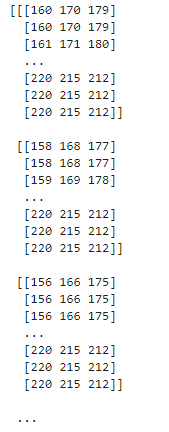

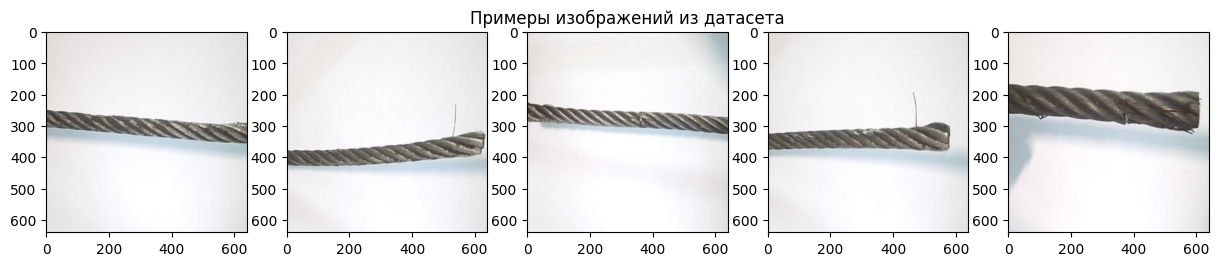

In [7]:
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(15, 9))
axes[2].set_title('Примеры изображений из датасета', loc='center')

axes[0].imshow(imgs[np.random.randint(0, len(imgs))])
axes[1].imshow(imgs[np.random.randint(0, len(imgs))])
axes[2].imshow(imgs[np.random.randint(0, len(imgs))])
axes[3].imshow(imgs[np.random.randint(0, len(imgs))])
axes[4].imshow(imgs[np.random.randint(0, len(imgs))])

plt.show()

*Первая проблема*, которую можно заметить в датасете - однообразие данных. На каждом изображении трос находится на одном и том же фоне в одном и том же положении. Это может привести к тому, что обученная модель будет хорошо находить дефекты исключительно на тросах из этого датасета.

**Объём датасета:** 305 изображений

Из них:

* **Обучающая выборка**: 214 (70%)  
* **Валидационная выборка**: 61 (20%)  
* **Тестовая выборка**: 30 (10%)  

*Вторая проблема* - относительно малое число данных.

In [13]:
with open('data.yaml', 'r') as file:
    dataset_data = yaml.safe_load(file)

In [14]:
print(f"Классы: {dataset_data['names']}")

Классы: ['divide', 'fracture', 'wear', 'wire']


**Число классов:** 4  
**Классы:**
* Расслоение троса (*Divide*)
* Трещина (*Fracture*)
* Износ троса (*Wear*)
* Одиночный провод (*Wire*)

Как было замечено ранее, в основе общей лежащей задачи лежит задача классификации (здесь мы имеем дело с мультиклассовой классификацией). Соберём статистику по каждой выборке и посмотрим на распределение классов.

In [15]:
def get_image_stats(directory):
    rows = {key: [] for key in ['filename', 0, 1, 2, 3]}

    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'r') as f:
            data = f.readlines()

            lbls = np.array([int(detect[0]) for detect in data])
            lbls, counts = np.unique(lbls, return_counts=True)
            lbls, counts = list(lbls), list(counts)

            rows['filename'].append(filename[:-4] + '.jpg')

            for key in range(4):
                if key not in lbls:
                    rows[key].append(0)
                else:
                    rows[key].append(counts[lbls.index(key)])

    df = pd.DataFrame(rows).fillna(0)
    return df

In [16]:
train_lbls_dir = 'datasets/Steel-rope-defect-detection-2/train/labels'
train_stats = get_image_stats(train_lbls_dir)
train_stats

,filename,0,1,2,3
0,0001_jpg.rf.3e2968fd78a1bba53d9719eb49d305d3.jpg,1,0,0,2
1,0002_jpg.rf.2fe16364d5a97d7a1dc5907c4d6bd9dc.jpg,0,0,0,2
2,0004_jpg.rf.46b9a4ae9e7677229442cec1a51dd507.jpg,0,0,0,1
3,0005_jpg.rf.74956d7fd7da5923ecf481fd359370b0.jpg,0,0,0,1
4,0006_jpg.rf.7037e6b03a8a2ca9d0f5f6d8768b4668.jpg,0,0,0,2
...,...,...,...,...,...
209,0301_jpg.rf.cdef05429fba706e8dd2b31e37618e5c.jpg,0,2,1,0
210,0302_jpg.rf.cfaeb33f7d5d6dfb870e6dad1e9cb00a.jpg,0,1,1,0
211,0303_jpg.rf.87358b74c09995236ec10f5e949cc076.jpg,0,1,1,0
212,0304_jpg.rf.89c01c1e4e5a2cca69b7983a50dbd278.jpg,0,1,1,0


Данная таблица показывает число объектов каждого типа, которые размечены на изображении.

In [12]:
dataset_lbls = []

for split in ['train', 'valid', 'test']:
    dir = f'datasets/Steel-rope-defect-detection-2/{split}/labels'

    stats = get_image_stats(dir)

    lbls_count = stats.iloc[:, 1:].sum(axis=0)
    lbls_count = lbls_count.rename(index=dict(enumerate(dataset_data['names'])))

    dataset_lbls.append(lbls_count)

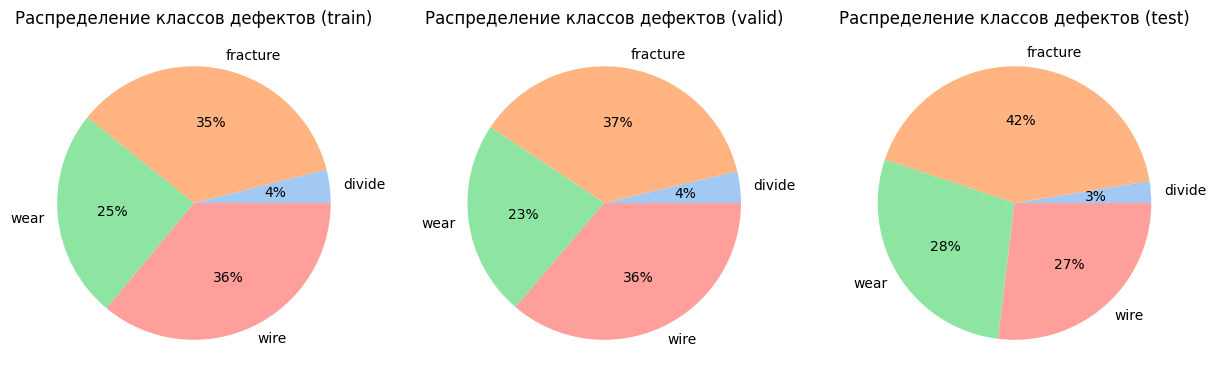

In [13]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 8))

colors = sns.color_palette('pastel')[:4]

for ind, split in enumerate(['train', 'valid', 'test']):
    axes[ind].set_title(f'Распределение классов дефектов ({split})')

    axes[ind].pie(dataset_lbls[ind],
                  labels=dataset_lbls[ind].index,
                  colors=colors, autopct='%.0f%%')

plt.show()

Очевидно, что класс **divide** представляет класс меньшинства. Это может привести к тому, что модель так и не научится различать дефекты этого типа. Более того, в силу такого же соотношения и на валидационной выборке, некоторые метрики (например, accuracy) могут давать обманчивый результат.

Это *третья* обнаруженная *проблема*.

Таким образом можно завершить этап предварительного анализа данных и перейти к их предобработке.

## Предобработка данных

Теперь перейдём к предобработке данных. Существует множество способов предобработки данных, каждые из которых выполняют свою задачу. Приведём некоторые техники:

* Изменение размера изображения (Image Resizing)
* Синтетическое увеличение датасета (Image Augmentation)
* Нормализация изображений (Image Normalization)
* Снижение шума (Noise Reduction)





### Изменение размера изображения (Image Resizing)

Обычно подразумевается, что все изображения в датасете имеют одинаковые измерения. Это способствует упрощению предобработки, ускорению обучения и экономии ресурсов памяти.

В выбранном датасете все изображения были уже предварительно приведены к формату 640x640.

### Снижение шума (Noise Reduction)

Снижение шума в основном используется для повышения качества самого изображения в случаях, когда шум может препятствовать распознанию объектов.

В выбранном датасете потребности в снижении шума нет.

### Нормализация изображений (Image Normalization)

Попиксельная нормализация изображений предполагает сведение значений численного представления пикселей к единому диапазону ($[0;1]$ или $[-1;1]$). Это способствует получению более стабильных моделей, уменьшению вероятности переобучения и также увеличению скорости обучения.

Сама нормализация выполняется достаточно просто: так как изображения хранятся в виде массива численных данных, достаточно просто разделить численное значение пикселя на 255.

Эти преобразования уже входят в функционал выбранной модели.

In [ ]:
dir = 'datasets/Steel-rope-defect-detection-2/train/images'
imgs = [imageio.imread(os.path.join(dir, filename)) for filename in os.listdir(dir)]

for ind in range(len(imgs)):
    imgs[ind] = imgs[ind] / 255

In [ ]:
imgs[0]

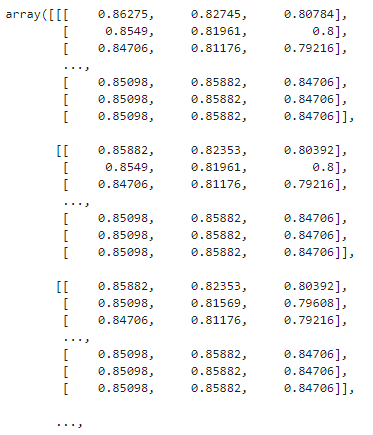

### Синтетическое увеличение датасета (Image Augmentation)

Данная техника может помочь улучшить качество датасета в условиях, когда дособрать больше данных не представляется возможным. Этот метод преда=полагает своершение ряда преобразований над изображениями для получения новых. Преобразования включают в себя:

* Афинные преобразования (поворот, масштабирование, сдвиг и т.д.)
* Изменение цвета/насыщенности/яркости
* Изменение контраста
* Добавление шума
* Добавление размытия/увеличение резкости
* и прочие

Подобные модификации не просто увеличивают датасет, но и делают модель, обученную на таких данных, более инвариантной к различным изменениям входных данных. Именно эту технику мы будем использовать для решения проблем, наёденных в датасете.

Однако стоит отметить, что есть риск переобучить модель на новых данных.

Для этого будет использоваться библиотека `imgaug`.

Для начала попытаемся решить проблему дисбаланса классов. Выберем все изображения, в которых содержатся примеры необходимого класса дефектов и применим к ним ряд преобразований. Не будем прибегать к сильным изменениям, попробуем сделать так, чтобы полученные данные как можно больше напоминали датасет.

Стоит отметить, что мы работаем с уже размеченными данными. Некоторые преобразования могут повлиять на расположение целевых объектов. Используемая библиотека позволяет это учесть.

Напишем функции, позволяющие считывать информацию о разметке данных, а также упрощающие процесс изменения изображений и сохранения результатов.

In [18]:
def read_boxes(directory, files=None):
    files = os.listdir(directory) if not files else files
    boxes = dict()

    for filename in files:
        with open(os.path.join(directory, filename), 'r') as f:
            f_data = f.readlines()
            f_data = list(map(lambda x: x.strip('\n').split(), f_data))

            filename = filename[:-4] + '.jpg'

            boxes[filename] = {i: list(map(float, coords)) for i, coords in enumerate(f_data)}

    return boxes

In [20]:
def augment_images(directory, augmentations, n=1, files=None):
    files = os.listdir(directory + '/images') if not files else files
    boxes = read_boxes(directory + '/labels',
                       files=list(map(lambda a: a[:-4] + '.txt', list(files))))

    old_images = [imageio.imread(directory + '/images/' + filename) for filename in files]
    shape = old_images[0].shape

    old_boxes = [BoundingBoxesOnImage([
                                        BoundingBox(
                                                    x1=(box[1]-box[3]/2)*640, x2=(box[1]+box[3]/2)*640,
                                                    y1=(box[2]-box[4]/2)*640, y2=(box[2]+box[4]/2)*640,
                                                    label=int(box[0])
                                                    ) for box in list(boxes[filename].values())
                                        ], shape=shape) for filename in files]
    new_images, new_boxes = augmentations(images=old_images * n,
                                          bounding_boxes=old_boxes * n)

    return new_images, list(map(lambda b: b.remove_out_of_image().clip_out_of_image(), new_boxes))

In [21]:
def save_augmented(directory, boxes, images, name='aug_'):
    for i in range(len(boxes)):
        filename = f'{name}{i}'
        imageio.imwrite(directory + '/images/'+ filename + '.jpg', images[i])

        with open(directory + '/labels/'+ filename + '.txt', 'w') as lbl:
            res = ''
            for box in boxes[i]:
                data = [str(box.label),
                        str(box.center_x/640), str(box.center_y/640),
                        str(box.width/640), str(box.height/640)]
                res = res + ' '.join(data) + '\n'

            lbl.write(res)

In [22]:
divide_files = list(train_stats[train_stats.loc[:, 0] != 0]['filename'])

#### Решение проблемы дисбаланса классов

Вообще существует множество других методов решения проблемы дисбаланса классов.

Например, мы можем уменьшить число примеров дргуих классов, но в таком случае рискуем ухудшить обобщающую способность модели. В случае нашего распределения классов это может сильно сказаться на качестве итоговой модели.

Также есть возможность доабвить в модели "отрицательные" примеры на основе FP предсказаний модели. Так появляется возможность скорректировать число ложноположительных предсказаний.

Есть также возможность найти дополнительные данные из других источников. Однако для целей данного исследования ограничимся только предобработкой существующего датасета.



Функция ниже предполагает применение в случайном порядке от двух перечисленных преобразований:

* Масштабирование по оси $Y$ в диапазоне от $0.75$ до $1.25$ (при масштабировании по оси X можем потерять информацию о каком-нибудь объекте в силу особенностей датасета)
* Поворот от $-25^{\circ}$ до $25^{\circ}$
* Гауссово размытие
* Отзеркаливание слева направо и сверху вниз
* Повышение резкости изображения

In [24]:
divide_aug = iaa.SomeOf((2, None), [
    iaa.ScaleY((0.75, 1.25)),
    iaa.Rotate((-25, 25)),
    iaa.GaussianBlur(sigma=(0.5, 2)),
    iaa.Fliplr(),
    iaa.Flipud(),
    iaa.Sharpen(alpha=(0.0, 0.3), lightness=(1, 1.1))
], random_order=True)

In [ ]:
new_divide, new_boxes = augment_images('datasets/Steel-rope-defect-detection-2/train',
                                       divide_aug, n=5, files=divide_files)

Посмотрим на получившиеся изображения.

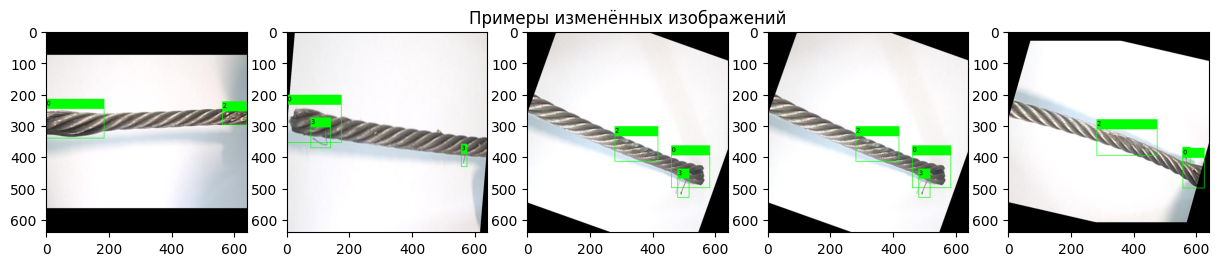

In [26]:
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(15, 9))
axes[2].set_title('Примеры изменённых изображений', loc='center')

for i in range(5):
    ind = np.random.randint(0, len(new_divide))

    bb_show = new_boxes[ind].draw_on_image(new_divide[ind], size=2)
    axes[i].imshow(bb_show)

plt.show()

In [27]:
save_augmented('datasets/Steel-rope-defect-detection-2/train', new_boxes, new_divide, name='div_aug_')

#### Решение проблемы малого разнообразия данных в датасете

Теперь решим сразу две оставшиеся проблемы. Используем технику синтетического увеличения датасета для добавления новых данных в весь датасет, а также для улучшения его репрезентативности.

Применим больший объём преобразований

In [28]:
total_aug = iaa.SomeOf((3, None), [
    # Affine transformations
    iaa.Rot90((1, 3)),
    iaa.ScaleY((0.75, 1.75)),
    iaa.Rotate((-25, 25)),

    iaa.Fliplr(),
    iaa.Flipud(),

    # Blurred/Sharp
    iaa.GaussianBlur(sigma=(0.5, 2.5)),
    iaa.Sharpen(alpha=(0.0, 0.5), lightness=(0.75, 1.3)),

    # Hue/Saturation
    iaa.MultiplyHueAndSaturation((0.5, 1.5), per_channel=True),

    # Noise
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)

], random_order=True)

Не станем увеличивать датасет слишком сильно, большое число синтетических данных может плохо отразиться на качестве модели.

In [ ]:
new_imgs, new_imgboxes = augment_images('datasets/Steel-rope-defect-detection-2/train',
                                        total_aug, n=2)
save_augmented('datasets/Steel-rope-defect-detection-2/train', new_imgboxes, new_imgs, name='aug_')

In [ ]:
new_imgs, new_imgboxes = augment_images('datasets/Steel-rope-defect-detection-2/valid',
                                        total_aug, n=2)
save_augmented('datasets/Steel-rope-defect-detection-2/valid', new_imgboxes, new_imgs, name='aug_')

Так мы увеличили нашу выборку в 3 раза.

## Обучение модели на предобработанных данных

Теперь можно обучить модель на предобработанных данных.

В качестве модели была выбрана **YOLOv8** (**Y**ou **O**nly **L**ook **O**nce). YOLOv8 - одноэтапная модель компьютерного зрения. В отличие от двухэтапных моделей, эта модель сразу выполняет задачи классификации и построения областей, пропуская этап предварительного анализа изображения на выявление областей, которые наиболее вероятно содержат нужный объект.

In [31]:
model = YOLO('yolov8n.pt')

In [ ]:
start = time.time()
results_prep = model.train(data='data.yaml', imgsz=640)
end = time.time()

time_prep = end - start

In [36]:
metrics_prep = model.val()

Ultralytics YOLOv8.2.12 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/datasets/Steel-rope-defect-detection-2/valid/labels.cache... 183 images, 0 backgrounds, 0 corrupt: 100%|██████████| 183/183 [00:00<?, ?it/s]
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


                   all        183        472      0.813      0.714      0.749       0.37
                divide        183         18      0.764      0.833      0.814      0.562
              fracture        183        172      0.873      0.837      0.855      0.344
                  wear        183        111      0.743      0.568       0.61      0.274
                  wire        183        171      0.872       0.62      0.718      0.302
Speed: 0.5ms preprocess, 6.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/train32


In [ ]:
dir = 'runs/detect/train3'
files = ['F1_curve.png', 'PR_curve.png']

graphs_prep = [imageio.imread(os.path.join(dir, filename)) for filename in files]

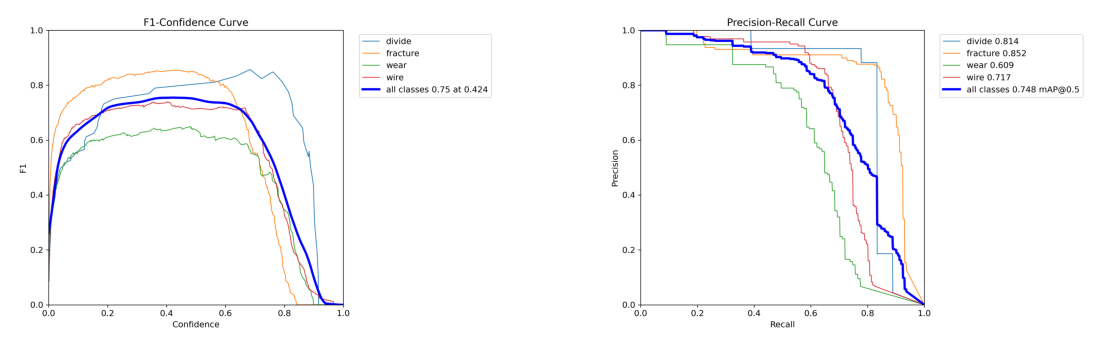

In [41]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 8))

axes[0].imshow(graphs_prep[0])
axes[0].axis('off')

axes[1].imshow(graphs_prep[1])
axes[1].axis('off')

plt.show()

Рассмотрим полученные метрики:

* **Precision** - метрика, показывающая долю правильно предсказанного положительного класса среди всех предсказанных положительных классов. По сути отражает точность предсказания.

  Значение метрики: 0.813

* **Recall** - метрика, показывающая долю правильно правильно предсказанного положительного класса среди всех объектов положительного класса. По сути отражает полноту предсказания.

  Значение метрики: 0.714

* **mAP50** - метрика, показывающая среднее значение точности модели с значением IoU (Intersection over Union) 0.5. Показывает общее качество модели.

  Значение метрики: 0.749

* **mAP50-95** - то же, что и выше, но берётся среднее между разными значениями показателя IoU.

  Значение метрики: 0.37

Можно сделать следующие выводы:

* Модель способна точно определять класс объекта, в предсказаниях невелика доля ложно положительных результатов.
* Однако способность модели выявлять наличие нужных объектов немного хуже. Возможно это связано с малым объемом данных. В этом случае стоит попытаться расширить датасет другими методами.
* Модель чувствительна к изменениям порога IoU. Это видно и на графиках.

## Выводы

В ходе работы были изучены основные подходы к сбору и предобработке данных. Рассмотрены случаи применения каждого метода предобработки и продемонстрированы реализации на языке Python. В качестве примера была построена модель. Метрики эффективности были проанализированы с точки зрения данных.